In [1]:
import glacierml as gl
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from scipy.stats import gaussian_kde


2023-09-01 10:21:47.386859: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 10:21:47.431808: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 10:21:48.137830: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = gl.parameterize_data('4')
df = df.drop('RGIId', axis = 1)
# df = df.drop(['RGIId','CenLat','CenLon','Zmed','Zmax','Aspect'],axis = 1)
df = df.drop(df[df['Thickness'] >= 300].index)
df = df.drop(df[df['Thickness'] == 267].index)
df = df.drop(df[df['Thickness'] == df['Thickness'].min()].index)

df = df.reset_index()
df = df.drop('index', axis = 1)
# create a copy of df to draw K test sets to be kept in a vault
df_sampler = df.copy()
df_trainer = df.copy()
rs = 42

2.0.0


In [4]:
trf, tef, trl, tel = gl.split_data(df,random_state = rs)
print(len(trf),len(tef))

270 68


In [5]:
df1test = df_sampler.sample(frac = 0.2,random_state = rs)
df_sampler = df_sampler.drop(df1test.index)

df2test = df_sampler.sample(frac = 0.25,random_state = rs)
df_sampler = df_sampler.drop(df2test.index)

df3test = df_sampler.sample(frac = 0.3333333,random_state = rs)
df_sampler = df_sampler.drop(df3test.index)

df4test = df_sampler.sample(frac = 0.5,random_state = rs)
df_sampler = df_sampler.drop(df4test.index)

df5test = df_sampler

print(len(df1test))
print(len(df2test))
print(len(df3test))
print(len(df4test))
print(len(df4test))

68
68
67
68
68


In [6]:
df1 = df_trainer.drop(df1test.index)
df2 = df_trainer.drop(df2test.index)
df3 = df_trainer.drop(df3test.index)
df4 = df_trainer.drop(df4test.index)
df5= df_trainer.drop(df5test.index)
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))
print(len(df4))

270
270
271
270
270


In [7]:
# trf, tef, trl, tel = gl.split_data(df1,random_state = 42)
# print(len(trf),len(tef))

In [8]:
dnn_model = {}
model = {}
model_history = {}
results = {}
normalizer = {}

In [9]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    min_delta = 0.001,
    patience = 10,
    verbose = 0,
    mode = 'auto',
    baseline = None,
    restore_best_weights = True
)

2023-09-01 10:22:11.992256: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


2/2 [==============================] - 0s 2ms/step - loss: 17.1379


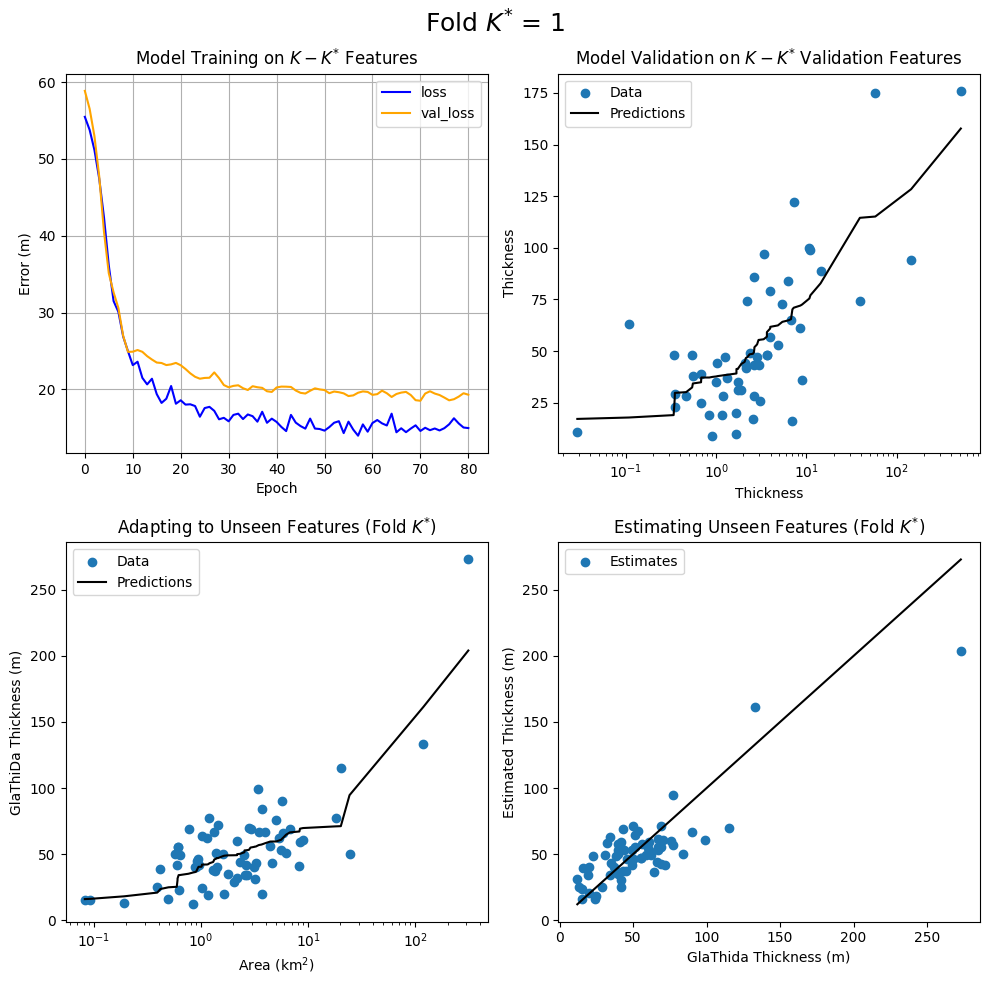

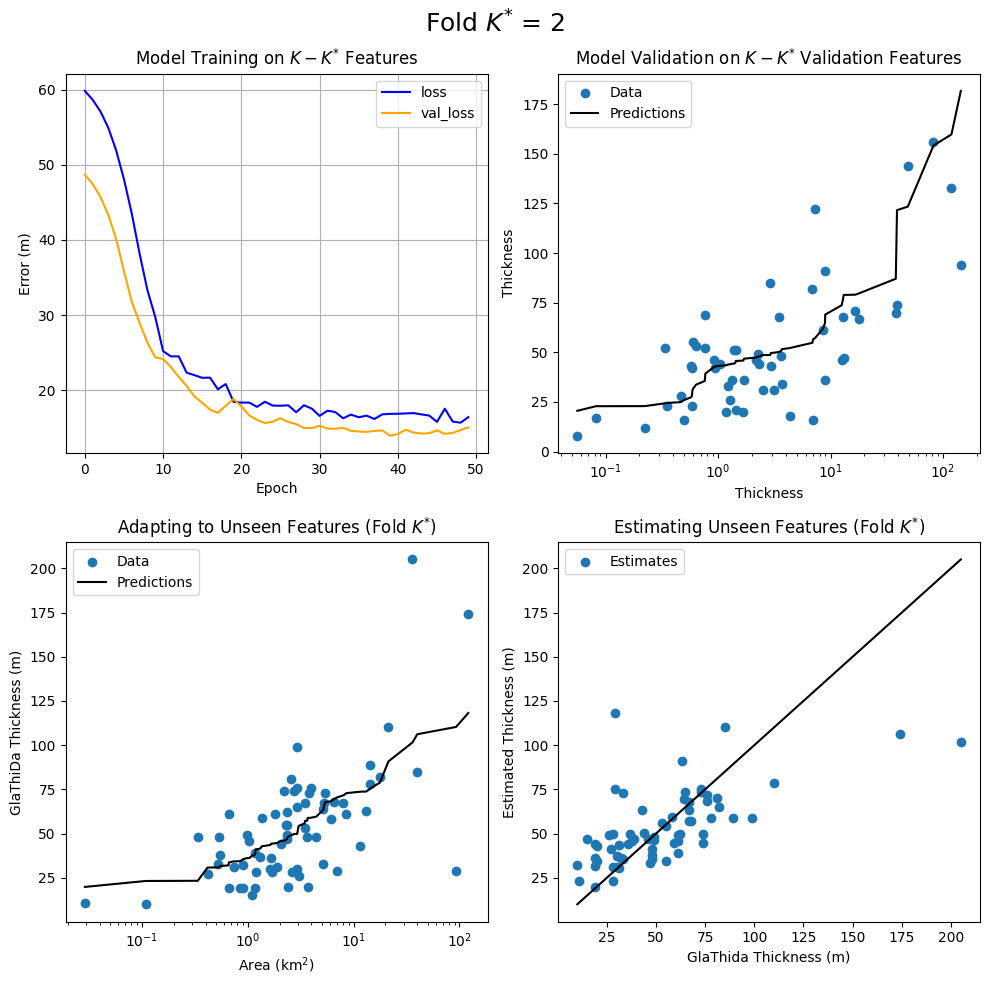

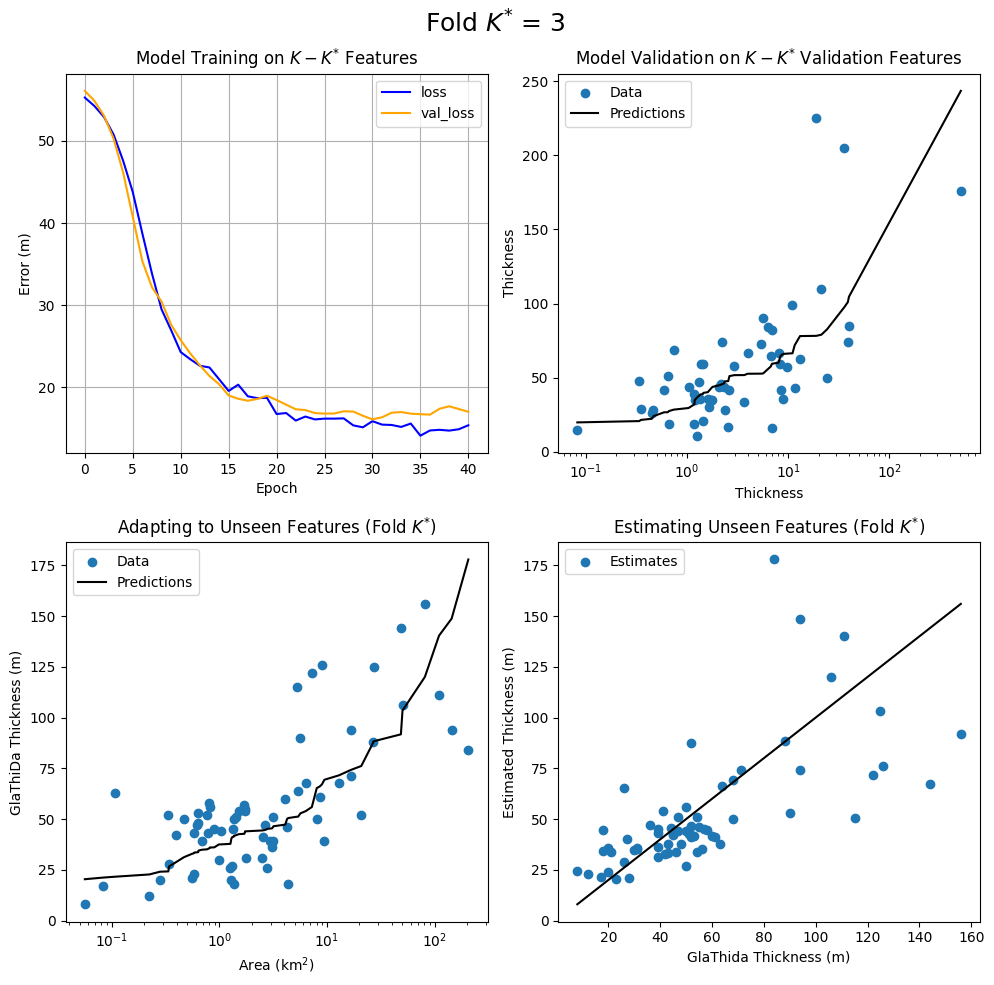

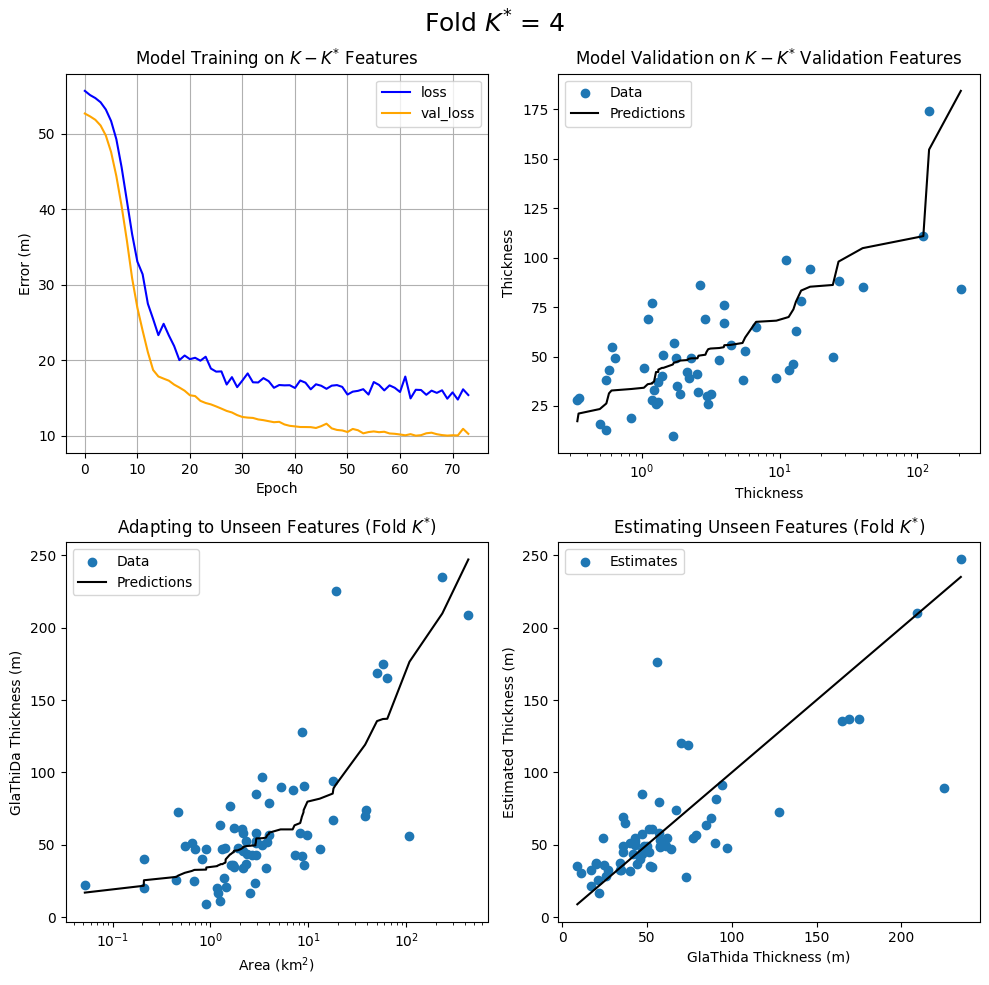

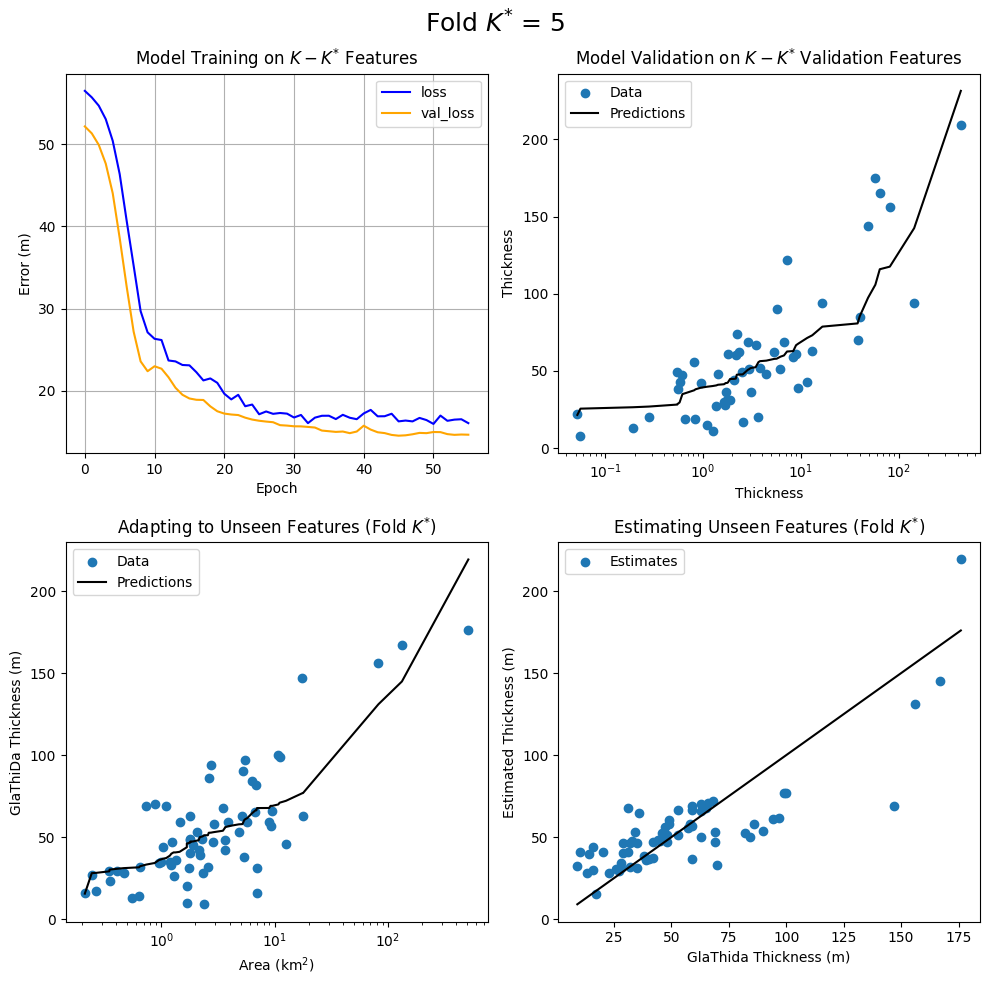

In [10]:
df_list = [df1,df2,df3,df4,df5]
test_df_list = [df1test,df2test,df3test,df4test,df5test]
k_list = ['1','2','3','4','5']
l1 = 10
l2 = 9
# k = '1'

for k,dft,dftest in zip(k_list,df_list,test_df_list):
#     k = str(k)
#     fig, ax = plt.subplots(2,2,figsize = (10,10))
    train_features, test_features, train_labels, test_labels = gl.split_data(dft,0)
    normalizer[k] = preprocessing.Normalization(axis=-1)
    normalizer[k].adapt(np.array(train_features))

    model[k] = gl.build_dnn_model(
        normalizer[k], learning_rate = 0.01, layer_1 = l1, layer_2 = l2,loss = 'mae'
    )

    model_history[k] = model[k].fit(
        train_features,
        train_labels,
        validation_split=0.2,
        callbacks = [callback],
        verbose=0, 
        epochs=2000
    )

    
    
    #     k = str(k)
    fig, ax = plt.subplots(2,2,figsize = (10,10))
    ax[0][0].plot(
        model_history[k].history['loss'], 
         label='loss',
        color = 'blue'
    )
    ax[0][0].plot(
        model_history[k].history['val_loss'], 
        label='val_loss',
        color = 'orange'
    )
    #   plt.ylim([0, 10])
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].set_ylabel('Error (m)')
    ax[0][0].legend()
    ax[0][0].grid(True)
    ax[0][0].set_title('Model Training on $K-K^{*}$ Features')
    
    
    y = model[k].predict(test_features).flatten()
    ax[0][1].scatter(test_features['Area'],test_labels,label = 'Data')
#     ax[0][1].plot(
#         test_labels.sort_values(
#         ascending = True),test_labels.sort_values(
#         ascending = True),c = 'r',label = 'Data'
#     )
    ax[0][1].plot(
        test_features['Area'].sort_values(
        ascending = True),np.sort(y),c = 'k',label = 'Predictions'
    )
    ax[0][1].set_xscale('log')
    ax[0][1].set_title('Model Validation on $K-K^{*}$ Validation Features')
    ax[0][1].set_xlabel('Thickness')
    ax[0][1].set_ylabel('Thickness')
    ax[0][1].legend()

    
    
    y = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()    
    ax[1][0].scatter(dftest['Area'],dftest['Thickness'],label = 'Data')
    ax[1][0].plot(
        dftest['Area'].sort_values(
        ascending = True),np.sort(y),c = 'k',label = 'Predictions'
    )
    ax[1][0].set_xscale('log')
    ax[1][0].set_title('Adapting to Unseen Features (Fold $K^{*}$)')
    ax[1][0].set_xlabel('Area (km$^2$)')
    ax[1][0].set_ylabel('GlaThiDa Thickness (m)')
    ax[1][0].legend()
#     plt.legend()
#     plt.show()
    
    
    
#     y = model[k].predict(dftest.drop('Thickness',axis = 1)).flatten()
    ax[1][1].scatter(dftest['Thickness'],y,label = 'Estimates')
    ax[1][1].plot(
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        (dftest['Thickness'].min(),dftest['Thickness'].max()),
        'k'
    )
    ax[1][1].set_title('Estimating Unseen Features (Fold $K^{*}$)')
    ax[1][1].set_xlabel('GlaThida Thickness (m)')
    ax[1][1].set_ylabel('Estimated Thickness (m)')
#     ax[1][1]
    fig.suptitle('Fold $K^{*}$ = ' + k,fontsize = 18)
    plt.tight_layout()
    save_title = 'xval'+k
    plt.savefig(f'img/img_{save_title}.png', 
                transparent = False,  
                facecolor = 'white'
               )
    ax[1][1].legend(loc = 'upper left')
#     ax[0][0] = gl.plot_loss(model_history[k].history)

#     plt.show()
    results[str(l1) + '-' + str(l2) + '_'+k] = model[k].evaluate(test_features, test_labels)


In [11]:
res = pd.DataFrame(results,index = ['Loss']).T

res.mean()

Loss    16.571749
dtype: float64

In [12]:

# frames = []
# for k in range(1,4,1):
#     save_path = 'xval'+str(k)
#     image = imageio.v2.imread(f'img/img_{save_path}.png')
#     frames.append(image)
# imageio.mimsave('xval_example.gif', # output gif
#                 frames,          # array of input frames
#                 duration = 8000,
#                 loop = 50
#                )   

In [13]:
selected_k = res[res['Loss'] == res['Loss'].min()].index.str[-1].values.flatten()[0]
selected_k = '5'

11/11 [==============================] - 0s 683us/step
0      225.024094
1       72.956589
2       75.778664
3       51.874676
4       42.037739
          ...    
333     42.977039
334     22.533001
335     45.651176
336     58.574818
337     84.806007
Length: 338, dtype: float32


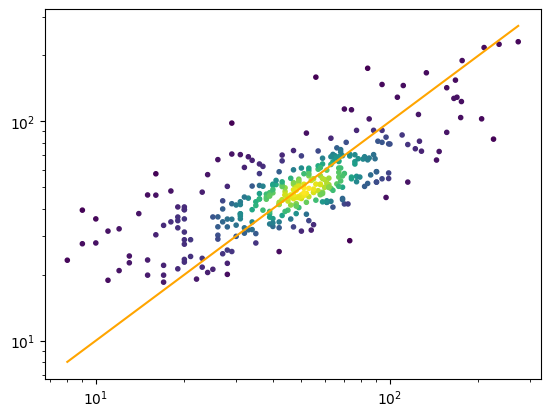

Residual Mean = -1.1474232306847205
Residual Standard Deviation = 22.90320163454559


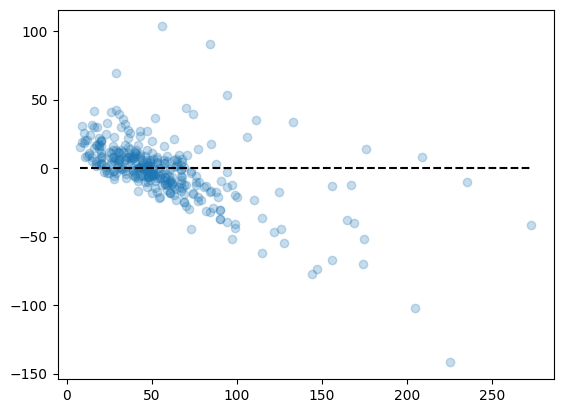

In [14]:
predictions = pd.DataFrame()
for k in k_list:
    y = pd.Series(
        model[k].predict(df.drop('Thickness',axis = 1)).flatten(),name = k
    )
    predictions = pd.concat([predictions, y], axis = 1)
y_avg = predictions.mean(axis = 1)
print(y_avg)
x = df['Thickness']
xy = np.vstack([np.log10(x),np.log10(y_avg)])
z = gaussian_kde(xy)(xy)
plt.scatter(x,y_avg,c =z,cmap = 'viridis',marker = '.')
plt.plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (df['Thickness'].min(),df['Thickness'].max()),
    c = 'orange'
)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.scatter(df['Thickness'],(y_avg - df['Thickness']) , alpha = 0.25)
plt.plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (0,0),
    c = 'k',
    linestyle = '--'
)

mean = (y_avg - df['Thickness']).mean()
print(f'Residual Mean = {mean}')

std = (y_avg - df['Thickness']).std()
print(f'Residual Standard Deviation = {std}')

11/11 [==============================] - 0s 676us/step


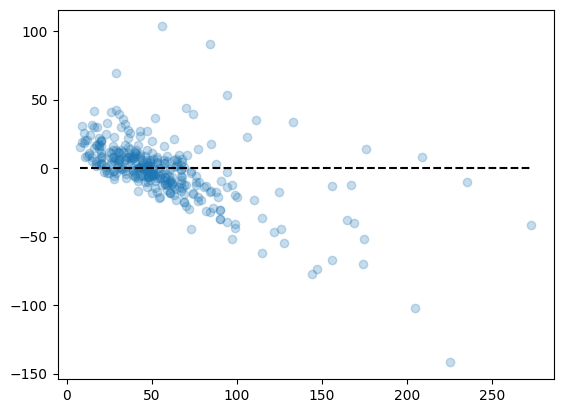

Residual Mean = -0.6400186154969345
Residual Standard Deviation = 23.42544654309816


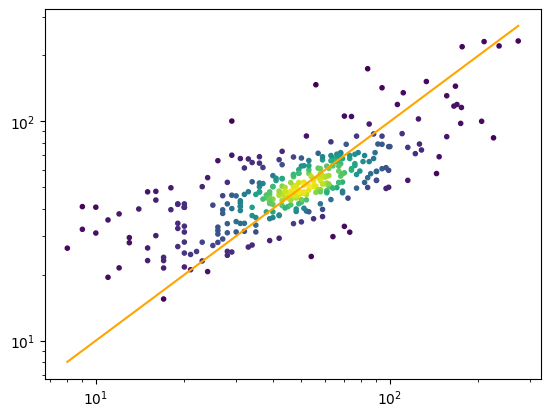

In [15]:
predictions = pd.DataFrame()
# for k in k_list:
y = pd.Series(
    model[selected_k].predict(df.drop('Thickness',axis = 1)).flatten(),name = k
)
predictions = pd.concat([predictions, y], axis = 1)
predictions

plt.scatter(df['Thickness'],(y_avg - df['Thickness']) , alpha = 0.25)
plt.plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (0,0),
    c = 'k',
    linestyle = '--'
)
plt.show()

y_avg = predictions.mean(axis = 1)
# print(y_avg)
# y_avg = y2.flatten()
x = df['Thickness']

xy = np.vstack([np.log10(x),np.log10(y_avg)])
z = gaussian_kde(xy)(xy)

plt.scatter(x,y_avg,c =z,cmap = 'viridis',marker = '.')
plt.plot(
    (df['Thickness'].min(),df['Thickness'].max()),
    (df['Thickness'].min(),df['Thickness'].max()),
    c = 'orange'
)
plt.xscale('log')
plt.yscale('log')
mean = (y_avg - df['Thickness']).mean()
print(f'Residual Mean = {mean}')

std = (y_avg - df['Thickness']).std()
print(f'Residual Standard Deviation = {std}')

In [16]:
RGI = gl.load_RGI()

2.0.0


In [17]:
list(train_features)

['CenLat', 'CenLon', 'Slope', 'Zmin', 'Zmed', 'Zmax', 'Area', 'Aspect', 'Lmax']

In [18]:
RGI = RGI[['CenLat', 'CenLon', 'Slope', 'Zmin', 'Zmed', 'Zmax', 'Area', 'Aspect', 'Lmax']]

In [19]:
y41 = model[selected_k].predict(RGI)

6766/6766 [==============================] - 4s 535us/step
